In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import numpy as np
import pickle,itertools
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,7)

import pickle

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [26]:
reg_all_class_val=xgb.Booster()
reg_all_class_val.load_model('./output/reg_all_classes_val.json')

reg_predicted_labels_val=xgb.Booster()
reg_predicted_labels_val.load_model('./output/Reg_predicted_labels_val.json')

reg_true_labels_val=xgb.Booster()
reg_true_labels_val.load_model('./output/reg_true_labels_val.json')

reg_class_val_0=xgb.Booster()
reg_class_val_0.load_model('./output/Reg_class0_validation.json')

In [18]:
train_set = pd.read_csv('./data/train_df_expanded_KNN_imp_3kfeats.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

with open("./output/y_train3_clf_preds.pkl", "rb") as f:
    y_val_class = pickle.load(f)

y_train0 = train_set['Target']
x_train0 = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1)
x_train0 = x_train0[reg_class_val_0.feature_names]

X_train0, X_test0, y_train0, y_test0 = train_test_split(x_train0, y_train0, test_size=0.15, shuffle=False)

X_test0.columns=x_train0.columns


X_test0 = X_test0.iloc[5:]
y_test0 = y_test0.iloc[5:]


X_test0['Class']=y_val_class[-len(X_test0):]


X_test0=xgb.DMatrix(X_test0[X_test0['Class']==0].drop(columns=['Class']))

## Regressor 1 : Train on predicted labels 

In [31]:
#Testing Regressor 1 : train on predicted labels 

y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1)
x_train = x_train[reg_predicted_labels_val.feature_names ]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

X_test = X_test.iloc[5:]
y_test = y_test.iloc[5:]
X_test.columns=x_train.columns


X_train['Class']=y_val_class[:len(X_train)]
X_test['Class']=y_val_class[-len(X_test):]

dval = xgb.DMatrix(X_test[X_test['Class']==1].drop(columns=['Class']), y_test[X_test['Class']==1])
X_test['Target']=y_test
X_test['Prediction']=0
X_test['Prediction'][X_test['Class']==1]=reg_predicted_labels_val.predict(dval)
X_test['Prediction'][X_test['Class']==0]=reg_class_val_0.predict(X_test0)

rmse = np.sqrt(mean_squared_error(X_test['Target'], X_test['Prediction']))
rmse



1.2287713849144064

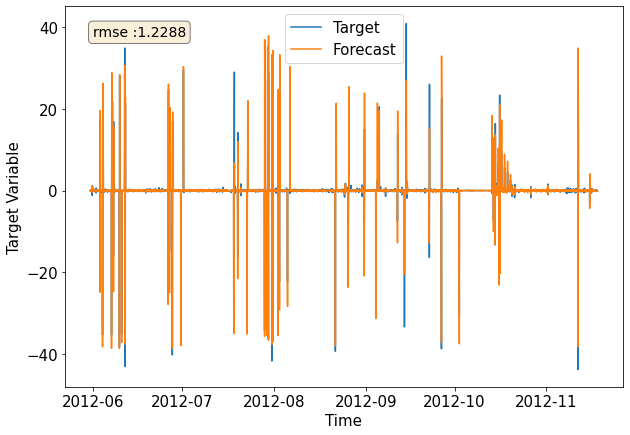

In [32]:
train_set['Date']=pd.to_datetime(train_set['Date'])
# plot the forecasted values against the real values
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Target'], label='Target')
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Prediction'], label='Forecast')
textstr = 'rmse :' + str(rmse.round(4)) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()

In [34]:
MAPE_class_1=mean_absolute_percentage_error(y_test[X_test['Class']==1], reg_predicted_labels_val.predict(dval), sample_weight=np.abs(y_test[X_test['Class']==1])/sum(np.abs(y_test[X_test['Class']==1])))
MAPE_class_1

0.28712292959431274

In [35]:
rmse_class_1 = np.sqrt(mean_squared_error( y_test[X_test['Class']==1], reg_predicted_labels_val.predict(dval)))
rmse_class_1

6.4895199597284625

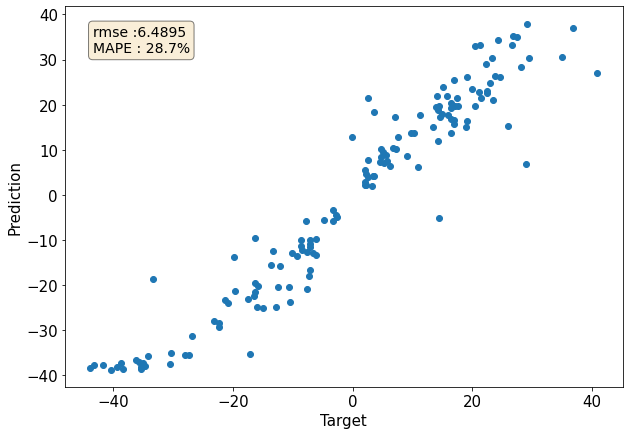

In [37]:
plt.scatter(X_test[X_test['Class']==1]['Target'], X_test[X_test['Class']==1]['Prediction'])
textstr = 'rmse :' + str(rmse_class_1.round(4)) +'\n' + 'MAPE : ' + str(100*MAPE_class_1.round(3)) +'%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.rcParams.update({'font.size': 15})
plt.show()

## Regressor 2 : Train on true labels

In [39]:
#Testing Regressor 2 : train on true labels 

y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1)
x_train = x_train[reg_true_labels_val.feature_names ]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

X_test = X_test.iloc[5:]
y_test = y_test.iloc[5:]
X_test.columns=x_train.columns


X_train['Class']=y_val_class[:len(X_train)]
X_test['Class']=y_val_class[-len(X_test):]

dval = xgb.DMatrix(X_test[X_test['Class']==1].drop(columns=['Class']), y_test[X_test['Class']==1])
X_test['Target']=y_test
X_test['Prediction']=0
X_test['Prediction'][X_test['Class']==1]=reg_true_labels_val.predict(dval)
X_test['Prediction'][X_test['Class']==0]=reg_class_val_0.predict(X_test0)

rmse = np.sqrt(mean_squared_error(X_test['Target'], X_test['Prediction']))
rmse


1.403750824548776

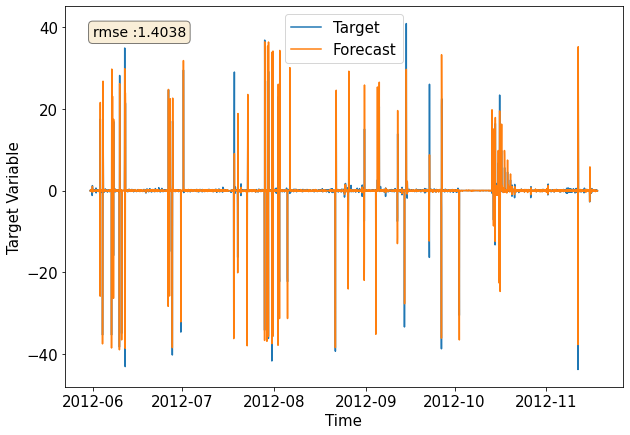

In [40]:
train_set['Date']=pd.to_datetime(train_set['Date'])
# plot the forecasted values against the real values
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Target'], label='Target')
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Prediction'], label='Forecast')
textstr = 'rmse :' + str(rmse.round(4)) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()

## Testing Regressor 3 : 1 regressor for both classes

In [42]:
#Testing Regressor 3 : train on both classes with same regressor

y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1)
x_train = x_train[reg_all_class_val.feature_names ]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

X_test = X_test.iloc[5:]
y_test = y_test.iloc[5:]
X_test.columns=x_train.columns



dval = xgb.DMatrix(X_test, y_test)
X_test['Target']=y_test
X_test['Prediction']=0
X_test['Prediction']=reg_all_class_val.predict(dval)

rmse = np.sqrt(mean_squared_error(X_test['Target'], X_test['Prediction']))
rmse


1.445850835000955

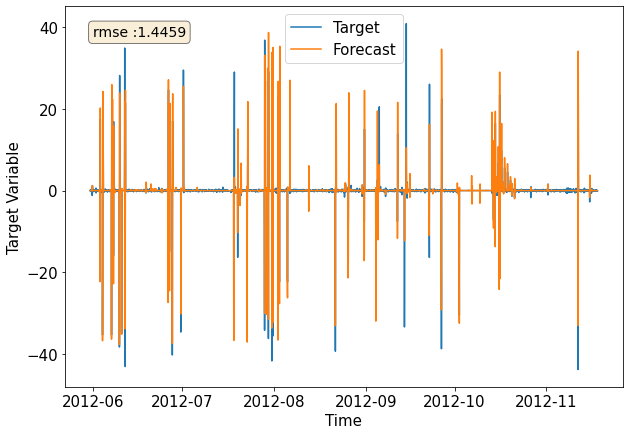

In [43]:
train_set['Date']=pd.to_datetime(train_set['Date'])
# plot the forecasted values against the real values
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Target'], label='Target')
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Prediction'], label='Forecast')
textstr = 'rmse :' + str(rmse.round(4)) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()

## Compute on testing test

In [44]:
reg_all_class=xgb.Booster()
reg_all_class.load_model('./output/Reg_all_classes.json')

reg_predicted_labels=xgb.Booster()
reg_predicted_labels.load_model('./output/Reg_predicted_labels.json')

reg_true_labels=xgb.Booster()
reg_true_labels.load_model('./output/reg_true_labels.json')

reg_class0=xgb.Booster()
reg_class0.load_model('./output/Reg_true_labels_class0.json')

In [45]:
with open("./output/y_test_clf_preds.pkl", "rb") as f:
    y_test_class = pickle.load(f)

In [46]:
# Load test set
df_test = pd.read_csv('./data/test_df_expanded_3kfeats.csv')
# Keep only the best X features for the test set
df_test_all=df_test[reg_all_class.feature_names]
df_test_all=df_test_all.replace([np.inf, -np.inf], np.nan)
df_test_all = xgb.DMatrix(df_test_all)


df_test_predicted=df_test[reg_predicted_labels.feature_names]
df_test_predicted=df_test_predicted.replace([np.inf, -np.inf], np.nan)
df_test_predicted['Class']=y_test_class
df_test_predicted = xgb.DMatrix(df_test_predicted[df_test_predicted['Class']==1].drop(columns=['Class']))


df_test_true=df_test[reg_true_labels.feature_names]
df_test_true=df_test_true.replace([np.inf, -np.inf], np.nan)
df_test_true['Class']=y_test_class
df_test_true = xgb.DMatrix(df_test_true[df_test_true['Class']==1].drop(columns=['Class']))

df_test_class0=df_test[reg_class0.feature_names]
df_test_class0=df_test_class0.replace([np.inf, -np.inf], np.nan)
df_test_class0['Class']=y_test_class
df_test_class0 = xgb.DMatrix(df_test_class0[df_test_class0['Class']==0].drop(columns=['Class']))



In [47]:
pred_all=reg_all_class.predict(df_test_all)
pred_predicted=reg_predicted_labels.predict(df_test_predicted)
pred_true=reg_true_labels.predict(df_test_true)

pred_class0=reg_class0.predict(df_test_class0)




In [48]:
test = pd.read_csv('./data/illinois_basing_test.csv')
test['Class']=y_test_class

In [49]:
pred_all[0]=0

test['Pred_all']=pred_all
pred_predicted[0]=0
test['Pred_predicted']=0
test['Pred_predicted'][test['Class']==1]=pred_predicted
test['Pred_predicted'][test['Class']==0]=pred_class0


pred_true[0]=0
test['pred_true']=0
test['pred_true'][test['Class']==1]=pred_true
test['pred_true'][test['Class']==0]=pred_class0




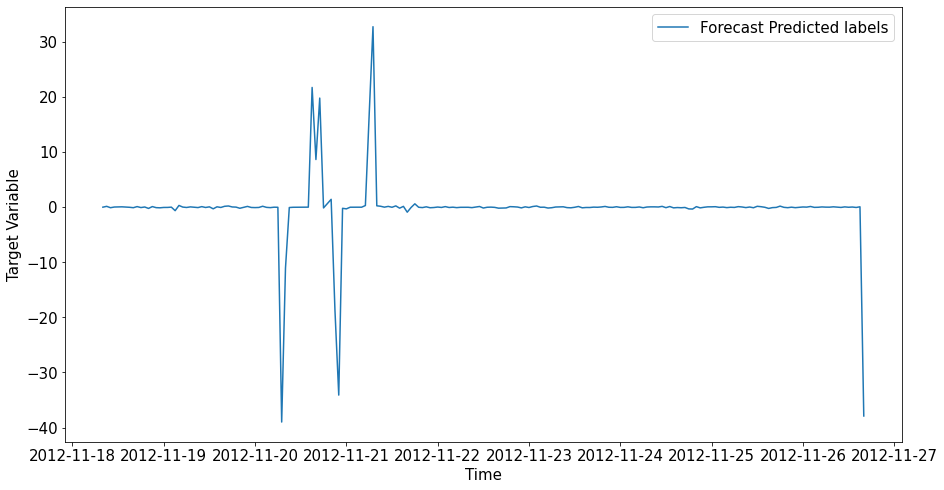

In [50]:
test['SampleTimeUTC']=pd.to_datetime(test['SampleTimeUTC'])
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 15})

# plot the forecasted values against the real values
#plt.plot(test['SampleTimeUTC'], test['Pred_all'], label='Forecast all')
plt.plot(test['SampleTimeUTC'], test['Pred_predicted'], label='Forecast Predicted labels')
#plt.plot(test['SampleTimeUTC'], test['pred_true'], label='Forecast True Labels')

plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

In [51]:
test.rename(columns={'Pred_predicted' : 'inj_diff'})['inj_diff'].to_csv('./output/Results Reg1 (PredictedLabels).csv',index=False)
test.rename(columns={'Pred_all' : 'inj_diff'})['inj_diff'].to_csv('./output/Results Reg2 (BothClasses).csv',index=False)
test.rename(columns={'pred_true' : 'inj_diff'})['inj_diff'].to_csv('./output/Results Reg3 (TrueLabels).csv',index=False)
